In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.tsa.seasonal import seasonal_decompose

import yfinance as yf
import pandas_ta as ta

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam, RMSprop, SGD
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

In [8]:
NAME = '0005.HK'

In [9]:
df = yf.download(NAME, start='2010-01-01', end = '2023-06-01')
df.reset_index(inplace=True)
df.drop('Close', axis=1, inplace=True)
df = df.rename(columns={'Adj Close': f'Close'})
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2010-01-04,89.400002,89.900002,88.800003,49.433346,10381759
1,2010-01-05,90.199997,90.650002,90.099998,50.098000,16914189
2,2010-01-06,91.300003,92.000000,91.250000,50.734947,20033996
3,2010-01-07,91.699997,91.750000,90.849998,50.541084,11163952
4,2010-01-08,91.500000,92.150002,91.349998,50.790337,15683744


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3306 entries, 0 to 3305
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3306 non-null   datetime64[ns]
 1   Open    3306 non-null   float64       
 2   High    3306 non-null   float64       
 3   Low     3306 non-null   float64       
 4   Close   3306 non-null   float64       
 5   Volume  3306 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 155.1 KB


In [11]:
df.describe()

,Date,Open,High,Low,Close,Volume
count,3306,3306.000000,3306.000000,3306.000000,3306.000000,3.306000e+03
mean,2016-09-13 17:01:24.936479232,65.245983,65.695951,64.849664,47.105637,2.262594e+07
min,2010-01-04 00:00:00,28.350000,28.650000,27.500000,25.206699,0.000000e+00
25%,2013-05-10 18:00:00,53.962501,54.349998,53.512500,41.367939,1.291332e+07
50%,2016-09-13 12:00:00,66.349998,66.875000,66.000000,47.216158,1.818494e+07
75%,2020-01-20 18:00:00,77.949997,78.300003,77.599998,52.715920,2.702276e+07
max,2023-05-31 00:00:00,92.000000,92.800003,92.000000,67.987373,2.757372e+08
std,NaN,14.598683,14.614717,14.607256,7.952084,1.654573e+07


In [12]:
null_sum = df['Close'].isnull().sum()
print(f"null before: {null_sum}")

df['Close'] = df['Close'].interpolate(method='linear')

after_null_sum = df.isnull().sum()
print(f"null after: {after_null_sum}")

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.dayofweek

null before: 0
null after: Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [13]:
df.head()

,Date,Open,High,Low,Close,Volume,Month,Day
0,2010-01-04,89.400002,89.900002,88.800003,49.433346,10381759,1,0
1,2010-01-05,90.199997,90.650002,90.099998,50.098000,16914189,1,1
2,2010-01-06,91.300003,92.000000,91.250000,50.734947,20033996,1,2
3,2010-01-07,91.699997,91.750000,90.849998,50.541084,11163952,1,3
4,2010-01-08,91.500000,92.150002,91.349998,50.790337,15683744,1,4


In [14]:
# Adding indicators
df['SMA_20'] = ta.sma(df['Close'], length=20, append=True)
df['SMA_253'] = ta.sma(df['Close'], length=253, append=True)
 
df['EMA_5'] = ta.ema(df['Close'], length=5, append=True)
df['EMA_20'] = ta.ema(df['Close'], length=20, append=True)
df['EMA_253'] = ta.ema(df['Close'], length=253, append=True)

df['RSI_14'] = ta.rsi(df['Close'], length=14, append=True)

df.ta.macd(fast=12, slow=26, signal=9, append=True)
df.ta.bbands(length=20, std=2, append=True)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
3301,56.089763,58.611104,61.132446,8.603632,0.626698
3302,56.800340,58.770759,60.741178,6.705439,0.393231
3303,57.336176,58.900498,60.464820,5.311744,0.451897
3304,58.173861,59.040228,59.906594,2.934835,0.390214


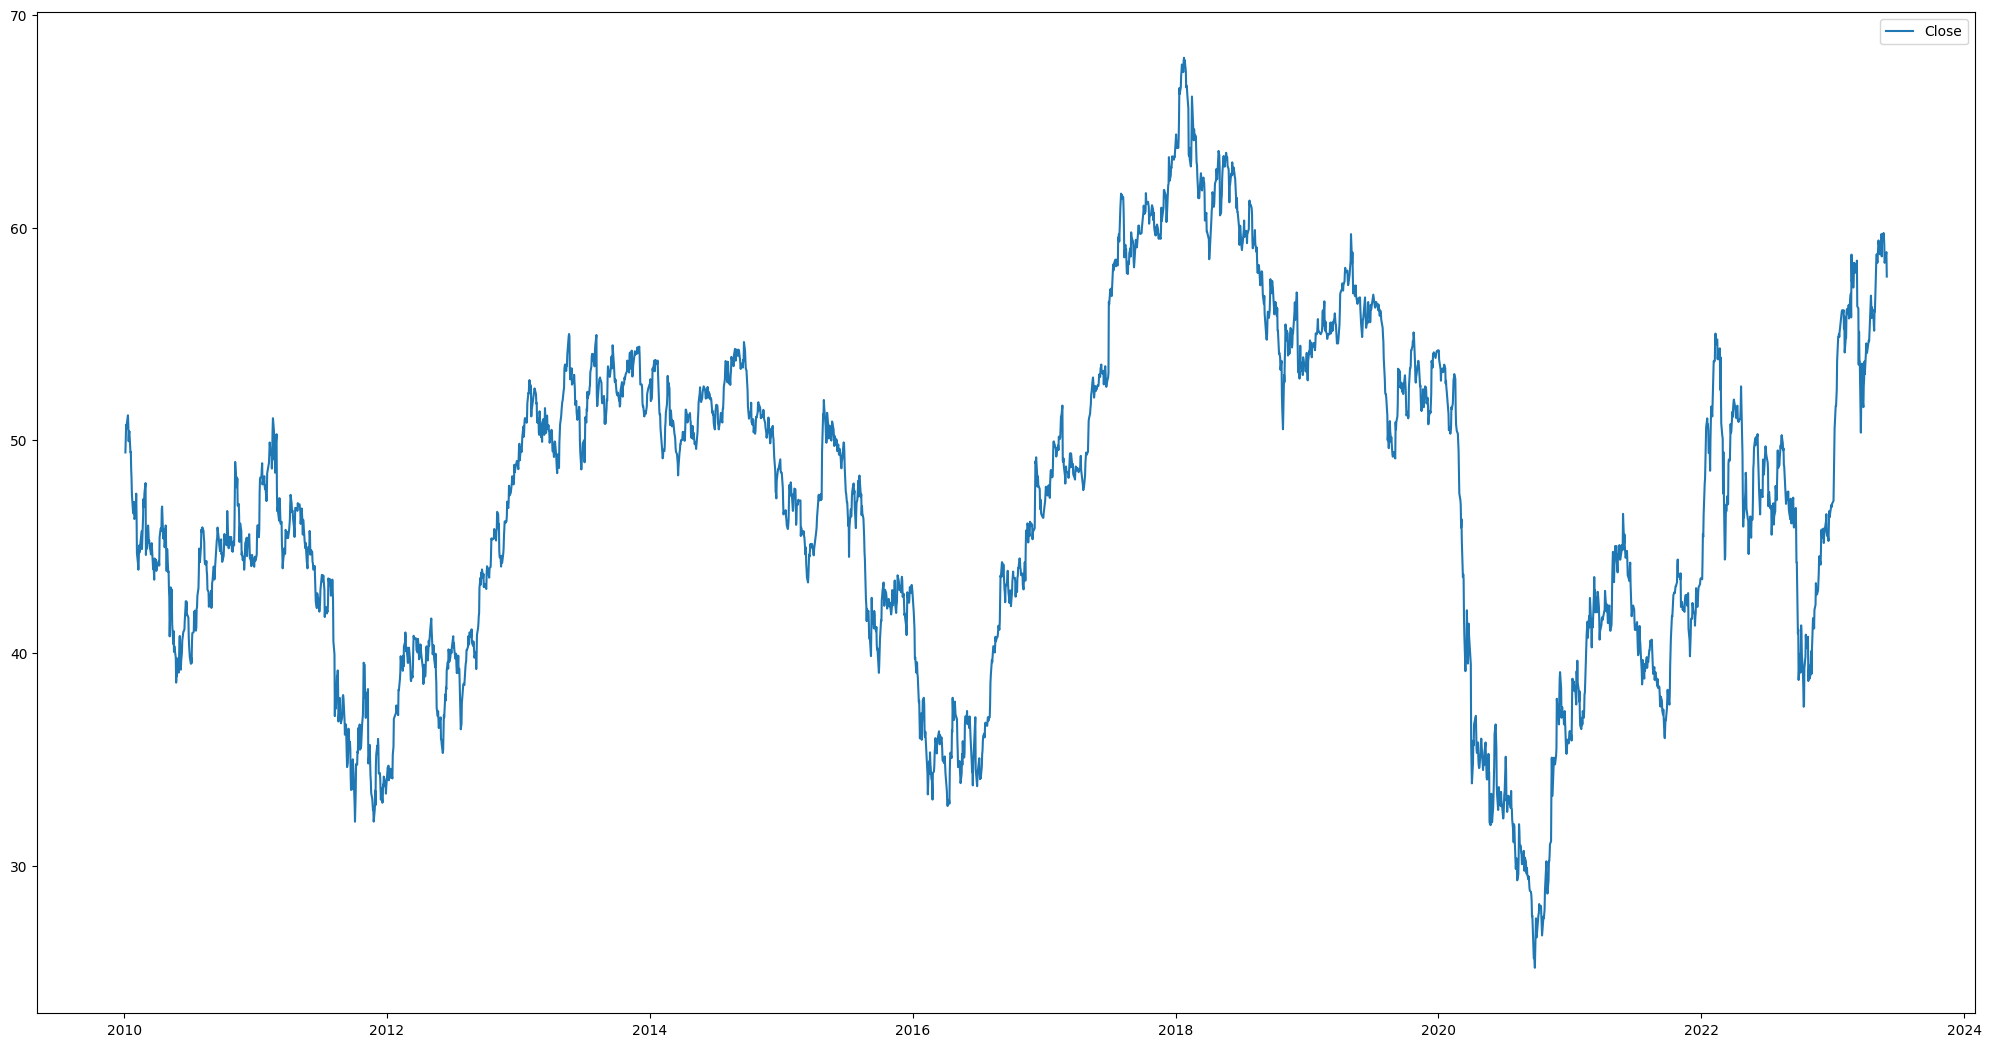

In [15]:
plt.figure(figsize=(25,13))

plt.plot(df['Date'], df['Close'], label='Close')

plt.legend(loc='best')
plt.show()

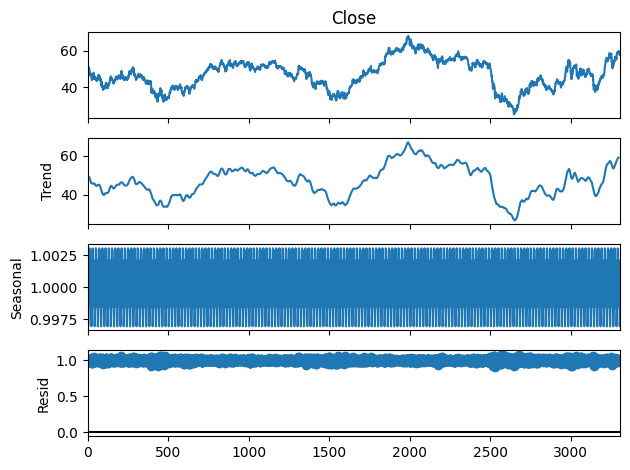

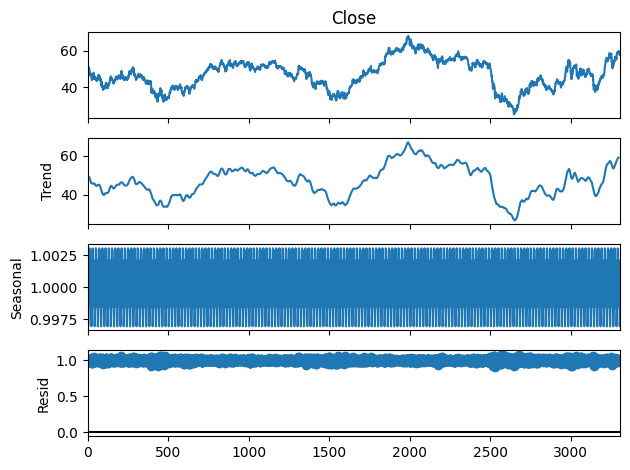

In [16]:
decompose = df['Close'].copy()
# checking seasonality in the price history (period: 5 trading days a week, 20 days a month, 253 days a year)
decompose_result_20 = seasonal_decompose(decompose, model="multiplicative", period=20) #period=5 also has full seasonal
decompose_result_20.plot()

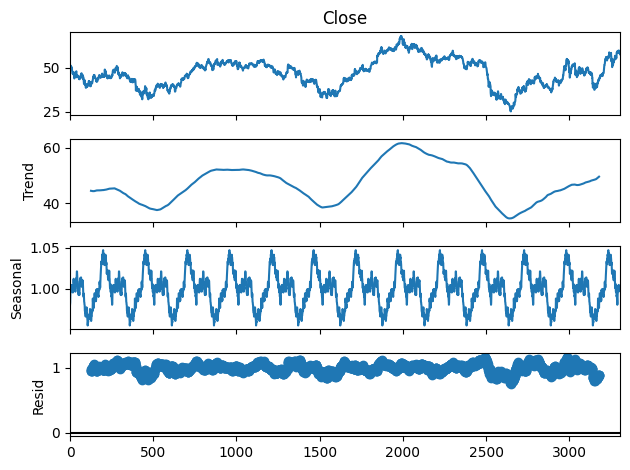

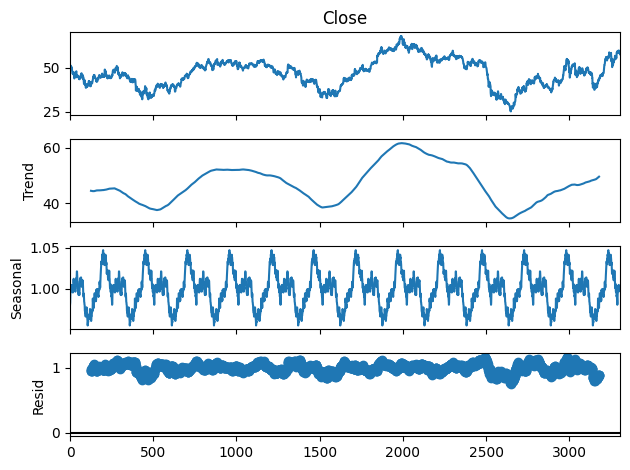

In [17]:
decompose_result_253 = seasonal_decompose(decompose, model="multiplicative", period=253) # clear yearly trend
decompose_result_253.plot()

In [18]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Month', 'Day',
       'SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'EMA_253', 'RSI_14',
       'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
       'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0'],
      dtype='object')

In [19]:
# feature engineering to prepare data
df['Lag1_Price'] = df['Close'].shift(1) # create feature of past 1-day price
df['Lag2_Price'] = df['Close'].shift(2) # past 2-days price

# one-hot encode the Month and Day columns
month_one_hot = pd.get_dummies(df['Month'], prefix='month', dtype=float)
day_one_hot = pd.get_dummies(df['Day'], prefix='day', dtype=float)

# concatenate the one-hot encoded columns to the original dataset
df = pd.concat([df, month_one_hot, day_one_hot], axis=1)
df = df.set_index(df['Date'])

df.dropna(inplace=True)
df.drop(columns=['Date', 'Month', 'Day', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)

In [20]:
train_df = df.loc[:'2023-05-02']
test_df = df.loc['2023-03-30':] #include 20 days before

In [21]:
X_train = train_df.drop('Close', axis=1)
y_train = train_df['Close']

X_test = test_df.drop('Close', axis=1)
y_test = test_df['Close']

In [22]:
# scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# create sequences of data using TimeseriesGenerator
sequence_length = 20
train_generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=32)
test_generator = TimeseriesGenerator(X_test, y_test, length=sequence_length, batch_size=32)

In [5]:
# function to calculate MAPE
def calculate_mape(y, y_pred):
    
  y_np = np.array(y)
  y_pred_np = np.array(y_pred)

  return round(np.mean(np.abs((y_np - y_pred_np) / y_np)) * 100, 4)

In [80]:
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [87]:
# defining the model architecture
model = Sequential()

# adding LSTM layers
model.add(LSTM(units=64, input_shape=(sequence_length, X_train.shape[1]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.1))

# adding dense layer
model.add(Dense(units=1))

# compiling the model
model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

# training the model
model.fit(train_generator, epochs=100, validation_data=test_generator)

Epoch 1/100
95/95 [==============================] - 14s 52ms/step - loss: 1858.4218 - val_loss: 2419.9756
Epoch 2/100
95/95 [==============================] - 3s 30ms/step - loss: 1317.7341 - val_loss: 2045.2627
Epoch 3/100
95/95 [==============================] - 3s 29ms/step - loss: 1085.9677 - val_loss: 1771.1035
Epoch 4/100
95/95 [==============================] - 3s 30ms/step - loss: 902.0372 - val_loss: 1539.7123
Epoch 5/100
95/95 [==============================] - 3s 30ms/step - loss: 754.7116 - val_loss: 1338.7136
Epoch 6/100
95/95 [==============================] - 3s 29ms/step - loss: 628.1580 - val_loss: 1165.6809
Epoch 7/100
95/95 [==============================] - 3s 30ms/step - loss: 518.3330 - val_loss: 1012.3405
Epoch 8/100
95/95 [==============================] - 3s 29ms/step - loss: 428.6338 - val_loss: 879.3563
Epoch 9/100
95/95 [==============================] - 3s 29ms/step - loss: 357.7896 - val_loss: 766.0541
Epoch 10/100
95/95 [==============================] -

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            25088     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 dropout_1 (Dropout)         (None, 20, 32)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [4]:
def eval_train_score(model, train_input, y_train):
    y_train_pred = model.predict(train_input).flatten()
    y_train_actual = np.array(y_train[sequence_length:])
    mape = calculate_mape(y_train_actual, y_train_pred)

    return mape

def eval_test_score(model, test_input, y_test):
    y_test_pred = model.predict(test_input).flatten()
    y_test_actual = np.array(y_test[sequence_length:])
    mape = calculate_mape(y_test_actual, y_test_pred)

    return y_test_pred, y_test_actual, mape

def plot_test(y_actual, y_pred):
    plt.title('Test Predictions')
    plt.plot(y_actual, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show() # plotting prediction on test and actual prices

In [23]:
print("Train MAPE: ", eval_train_score(model, train_generator, y_train))

95/95 [==============================] - 1s 4ms/step
Train MAPE:  1.5727


1/1 [==============================] - 0s 31ms/step
Test MAPE:  0.7199


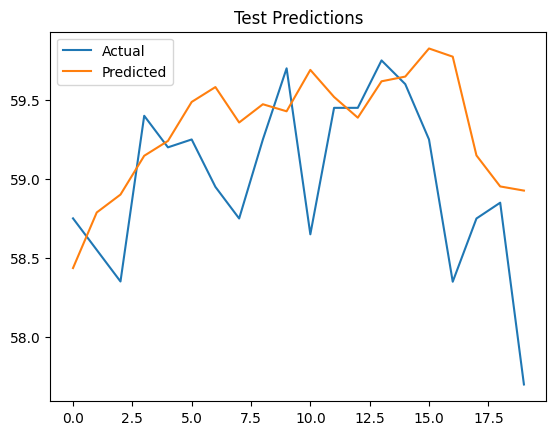

In [24]:
y_pred, y_actual, test_mape = eval_test_score(model, test_generator, y_test)
print("Test MAPE: ", test_mape)
plt.title('Test Predictions')
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show() # plotting prediction on test and actual prices

In [115]:
model.save('lstm_hsbc.h5')

In [2]:
from keras.models import load_model
model = load_model('lstm_hsbc.h5')

In [39]:
def build_model(hp):
        model = Sequential()
        model.add(LSTM(hp.Int('lstm_0_units',min_value=64,max_value=128,step=32),return_sequences=True, input_shape=(sequence_length, X_train.shape[1])))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.5,step=0.1)))

        model.add(LSTM(hp.Int(f'lstm_1_units',min_value=32,max_value=64,step=32),return_sequences=True))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.3,step=0.1)))

        model.add(LSTM(units=32))
        model.add(Dropout(hp.Float('dropout',min_value=0.1,max_value=0.3,step=0.1)))

        model.add(Dense(units=1))

        optimizer = Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log'))

        model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])

        return model

K.clear_session()

tuner= kt.RandomSearch(
        build_model,
        objective='val_mse',
        max_trials=10,
        executions_per_trial=3,
        directory='tuned_model',
        project_name='lstm_hsbc_tuned',
        overwrite=True
        )

tuner.search(
        train_generator,
        epochs=100,
        validation_data=test_generator,
)

Trial 10 Complete [00h 12m 44s]
val_mse: 0.31039562821388245

Best val_mse So Far: 0.2433865616718928
Total elapsed time: 02h 05m 22s
INFO:tensorflow:Oracle triggered exit


In [40]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            25088     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

95/95 [==============================] - 2s 10ms/step
Train MAPE:  1.8783
1/1 [==============================] - 0s 38ms/step
Test MAPE:  0.6994


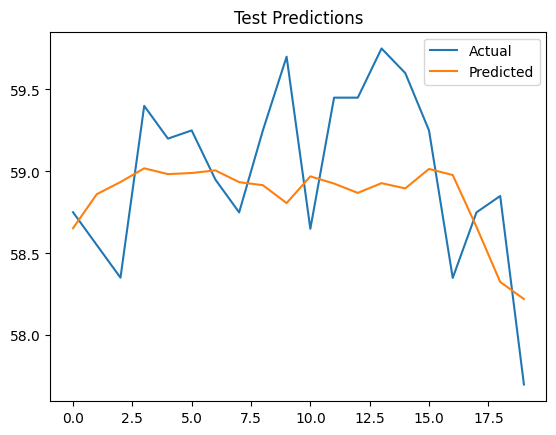

In [41]:
print("Train MAPE: ", eval_train_score(best_model, train_generator, y_train))
y_pred, y_actual, test_mape = eval_test_score(best_model, test_generator, y_test)
print("Test MAPE: ", test_mape)
plt.title('Test Predictions')
plt.plot(y_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show() # plotting prediction on test and actual prices

In [42]:
best_model.save('lstm_hsbc_tuned.h5')

In [92]:
future_dates = pd.date_range(start='2023-06-01', end='2023-06-30', freq='B') #generate only trading days, excluding holidays
future_dates

DatetimeIndex(['2023-06-01', '2023-06-02', '2023-06-05', '2023-06-06',
               '2023-06-07', '2023-06-08', '2023-06-09', '2023-06-12',
               '2023-06-13', '2023-06-14', '2023-06-15', '2023-06-16',
               '2023-06-19', '2023-06-20', '2023-06-21', '2023-06-22',
               '2023-06-23', '2023-06-26', '2023-06-27', '2023-06-28',
               '2023-06-29', '2023-06-30'],
              dtype='datetime64[ns]', freq='B')

In [101]:
# predicting future prices by calculating each features one-by-one and iteratively predicting the next day price
history_train_df = train_df.copy()
history_train_df = history_train_df.loc[:, ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'EMA_253', 'RSI_14',
                                            'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
                                            'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'Lag1_Price',
                                            'Lag2_Price', 'Close']]

history_test_df = test_df.drop('Close', axis=1)
history_test_df = history_test_df.loc['2023-05-03':]
history_test_df['Close'] = y_pred # add the predicted price from test data
history_test_df = history_test_df.loc[:, ['SMA_20', 'SMA_253', 'EMA_5', 'EMA_20', 'EMA_253', 'RSI_14',
                                        'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'BBL_20_2.0',
                                        'BBM_20_2.0', 'BBU_20_2.0', 'BBB_20_2.0', 'BBP_20_2.0', 'Lag1_Price',
                                        'Lag2_Price', 'Close']]

history_pred_df = pd.concat([history_train_df, history_test_df])

for date in future_dates:
    target_date = str(date.date())
    print(target_date)

    prev_5_days = history_pred_df.loc[:target_date].tail(5) # EMA
    prev_20_days = history_pred_df.loc[:target_date].tail(20) # SMA,EMA,RSI,BBANDS
    prev_35_days = history_pred_df.loc[:target_date].tail(35) # MACD
    prev_253_days = history_pred_df.loc[:target_date].tail(253) # SMA, EMA
    

    # SMA and EMA from predicted price for the target_date
    SMA_20 = ta.sma(prev_20_days['Close'], length=20)[-1]
    SMA_253 = ta.sma(prev_253_days['Close'], length=253)[-1]
    EMA_5 = ta.ema(prev_5_days['Close'], length=5)[-1]
    EMA_20 = ta.ema(prev_20_days['Close'], length=20)[-1]
    EMA_253 = ta.ema(prev_253_days['Close'], length=253)[-1]

    MACD = prev_35_days.ta.macd(fast=12, slow=26, signal=9).iloc[-1]

    BB = prev_20_days.ta.bbands(length=20, std=2).iloc[-1]

    # assign Lag1_Price as the predicted price for the previous business day
    lag1_date = pd.date_range(end=target_date, periods=2, freq='B')[0]
    lag1_df = history_pred_df.loc[history_pred_df.index <= lag1_date]
    Lag1_Price = lag1_df.iloc[-1]['Close']

    # assign Lag2_Price as the predicted price for two business days ago
    lag2_date = pd.date_range(end=target_date, periods=3, freq='B')[0]
    lag2_df = history_pred_df.loc[history_pred_df.index <= lag2_date]
    Lag2_Price = lag2_df.iloc[-1]['Close']

    RSI_14 = ta.rsi(prev_20_days['Close'], length=14)[-1]
    # MACD BBANDS GIMANAA!!?!?!?!?!?!?!!?

    # create a DataFrame for the features of the target date
    X_features_date = pd.DataFrame({
        'SMA_20': [SMA_20],
        'SMA_253': [SMA_253],
        'EMA_5': [EMA_5],
        'EMA_20': [EMA_20],
        'EMA_253': [EMA_253],
        'RSI_14': [RSI_14],
        'MACD_12_26_9' : [MACD['MACD_12_26_9']],
        'MACDh_12_26_9' : [MACD['MACDh_12_26_9']],
        'MACDs_12_26_9' : [MACD['MACDs_12_26_9']],
        'BBL_20_2.0' : [BB['BBL_20_2.0']],
        'BBM_20_2.0' : [BB['BBM_20_2.0']],
        'BBU_20_2.0' : [BB['BBU_20_2.0']],
        'BBB_20_2.0' : [BB['BBB_20_2.0']],
        'BBP_20_2.0' : [BB['BBP_20_2.0']],
        'Lag1_Price': [Lag1_Price],
        'Lag2_Price': [Lag2_Price],
    }, index=[pd.to_datetime(target_date)])

    X_prev_20_days = history_pred_df.loc[:target_date].tail(20).drop('Close', axis=1)

    X_features_forecast = pd.concat([X_prev_20_days, X_features_date])
    X_features_forecast.reset_index(inplace=True)
    X_features_forecast = X_features_forecast.rename(columns = {'index':'Date'})
    X_features_forecast['Month'] = X_features_forecast['Date'].dt.month
    X_features_forecast['Day'] = X_features_forecast['Date'].dt.dayofweek

    # Create an empty DataFrame with columns for all one-hot encoded features
    one_hot_cols = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4']

    if 5 in X_features_forecast['Month'].unique():
        remained_one_hot_cols = [ 'month_1', 'month_2', 'month_3', 'month_4', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']
    else:
        remained_one_hot_cols = [ 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

    # one-hot encode the Month and Day columns
    month_one_hot = pd.get_dummies(X_features_forecast['Month'], prefix='month', dtype=float)
    day_one_hot = pd.get_dummies(X_features_forecast['Day'], prefix='day', dtype=float)

    # combine one-hot encoded dataframes
    one_hot_df = pd.concat([month_one_hot, day_one_hot], axis=1)
    for col in remained_one_hot_cols:
        one_hot_df[col] = 0

    one_hot_df = one_hot_df[one_hot_cols]

    # concatenate the one-hot encoded columns to the original dataset
    X_features_forecast = pd.concat([X_features_forecast, one_hot_df], axis=1)

    # preparing features for prediction
    X_features_forecast = X_features_forecast.set_index(X_features_forecast['Date'])
    X_features_forecast.drop(columns=['Date', 'Month', 'Day'], axis=1, inplace=True)

    date_index = []
    X_forecast = []

    for i in range(len(X_features_forecast)-sequence_length+1):
        X_forecast.append(X_features_forecast.iloc[i:i+sequence_length].values)
        date_index.append(X_features_forecast.index[i+sequence_length-1])
        
    X_forecast = np.array(X_forecast)
    date_index = np.array(date_index)

    X_forecast = X_forecast.reshape(-1, X_train.shape[-1])
    # scale the X_feature_forecasts data
    X_features_forecast_scaled = scaler.transform(X_forecast)

    sequence_length = 20

    # create a TimeseriesGenerator object for X_feature_forecasts
    feature_generator = TimeseriesGenerator(X_features_forecast_scaled, np.zeros(len(X_features_forecast_scaled)), length=sequence_length, batch_size=1)

    # predict next day price
    predicted_price = model.predict(feature_generator)

    # get last day of the prediction
    X_features_date['Close'] = predicted_price[-1][-1]
    history_pred_df = pd.concat([history_pred_df, X_features_date])
    print("===================== done adding ================")

2023-06-01
20/20 [==============================] - 1s 3ms/step
===================== done adding ================
2023-06-02
20/20 [==============================] - 0s 3ms/step
===================== done adding ================
2023-06-05
20/20 [==============================] - 0s 3ms/step
===================== done adding ================
2023-06-06
20/20 [==============================] - 0s 2ms/step
===================== done adding ================
2023-06-07
20/20 [==============================] - 0s 2ms/step
===================== done adding ================
2023-06-08
20/20 [==============================] - 0s 2ms/step
===================== done adding ================
2023-06-09
20/20 [==============================] - 0s 2ms/step
===================== done adding ================
2023-06-12
20/20 [==============================] - 0s 2ms/step
===================== done adding ================
2023-06-13
20/20 [==============================] - 0s 2ms/step
================

In [102]:
observed_period = history_pred_df.loc['2023-05-03':'2023-05-31']
forecast_period = history_pred_df.loc['2023-06-01':]

In [103]:
observed_period

,SMA_20,SMA_253,EMA_5,EMA_20,EMA_253,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,Lag1_Price,Lag2_Price,Close
2023-05-03,55.638597,48.620365,57.416135,55.930556,49.737130,67.050902,0.758329,0.336532,0.421797,52.976206,55.638597,58.300988,9.570302,1.084483,58.551182,56.055393,57.845387
2023-05-04,55.910638,48.647339,57.794484,56.180139,49.806532,65.599580,0.868781,0.357587,0.511194,53.225393,55.910638,58.595882,9.605486,0.991677,58.750843,58.551182,58.341080
2023-05-05,56.122779,48.682963,57.980162,56.386937,49.873815,64.105252,0.929489,0.334636,0.594853,53.370928,56.122779,58.874631,9.806542,0.904952,58.551182,58.750843,58.370380
2023-05-08,56.364871,48.730848,58.453358,56.673872,49.948822,68.200711,1.050079,0.364181,0.685898,53.365503,56.364871,59.364239,10.642685,1.005920,58.351517,58.551182,58.348358
2023-05-09,56.619441,48.783229,58.702267,56.914463,50.021667,66.641007,1.116664,0.344613,0.772051,53.565494,56.619441,59.673388,10.787627,0.922510,59.399750,58.351517,58.442444
2023-05-10,56.846558,48.832976,58.884844,57.136895,50.094331,66.845142,1.160088,0.310430,0.849659,53.720337,56.846558,59.972779,10.998805,0.884401,59.200085,59.399750,58.620998
2023-05-11,57.061170,48.882670,58.906563,57.309572,50.164061,64.298456,1.156958,0.245840,0.911119,53.976410,57.061170,60.145930,10.812117,0.806155,59.250000,59.200085,59.027943
2023-05-12,57.240825,48.926854,58.854375,57.446756,50.231667,62.586539,1.125367,0.171399,0.953968,54.202432,57.240825,60.279217,10.616174,0.748351,58.950001,59.250000,58.951298
2023-05-15,57.428009,48.969428,58.986250,57.618493,50.302677,65.089001,1.127677,0.138967,0.988710,54.378856,57.428009,60.477161,10.619044,0.798770,58.750000,58.950001,58.846283
2023-05-16,57.572802,49.014912,59.224167,57.816732,50.376672,67.214446,1.152533,0.131059,1.021475,54.384069,57.572802,60.761535,11.077219,0.833549,59.250000,58.750000,58.838978


In [104]:
y_actual

array([58.75084305, 58.55118179, 58.35151672, 59.39974976, 59.20008469,
       59.25      , 58.95000076, 58.75      , 59.25      , 59.70000076,
       58.65000153, 59.45000076, 59.45000076, 59.75      , 59.59999847,
       59.25      , 58.34999847, 58.75      , 58.84999847, 57.70000076])

In [105]:
forecast_period['Close']

2023-06-01    58.279404
2023-06-02    57.995079
2023-06-05    58.436752
2023-06-06    58.419258
2023-06-07    59.157619
2023-06-08    59.398407
2023-06-09    59.931946
2023-06-12    60.584553
2023-06-13    60.979004
2023-06-14    61.355812
2023-06-15    61.620602
2023-06-16    61.784447
2023-06-19    61.998730
2023-06-20    62.113361
2023-06-21    62.191765
2023-06-22    62.243427
2023-06-23    62.263100
2023-06-26    62.294086
2023-06-27    62.296631
2023-06-28    62.306419
2023-06-29    62.310658
2023-06-30    62.304451
Name: Close, dtype: float64

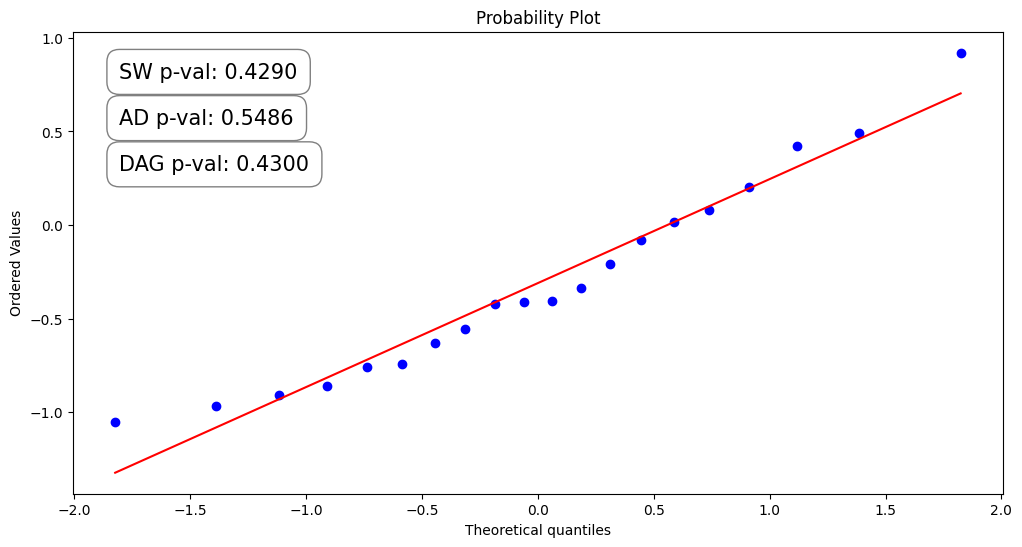

In [106]:
# calculate residuals from observed period
residuals = sorted([x - y for x, y in zip(y_pred, y_actual)])

# check normal dist from residuals using smirnov-kolmogorov, anderson-darling, d'agostino k-squared tests
# reference: https://towardsdatascience.com/time-series-forecasting-prediction-intervals-360b1bf4b085
sw_result = stats.shapiro(residuals)
ad_result = normal_ad(np.array(residuals), axis=0)
dag_result = stats.normaltest(residuals, axis=0, nan_policy='propagate')

plt.figure(figsize=(12, 6))
res = stats.probplot(residuals, plot=plt)
ax = plt.gca()
ax.annotate("SW p-val: {:.4f}".format(sw_result[1]), xy=(0.05,0.9), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("AD p-val: {:.4f}".format(ad_result[1]), xy=(0.05,0.8), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))
ax.annotate("DAG p-val: {:.4f}".format(dag_result[1]), xy=(0.05,0.7), xycoords='axes fraction', fontsize=15,
            bbox=dict(boxstyle="round", fc="none", ec="gray", pad=0.6))

plt.show()

In [107]:
len(y_actual)

20

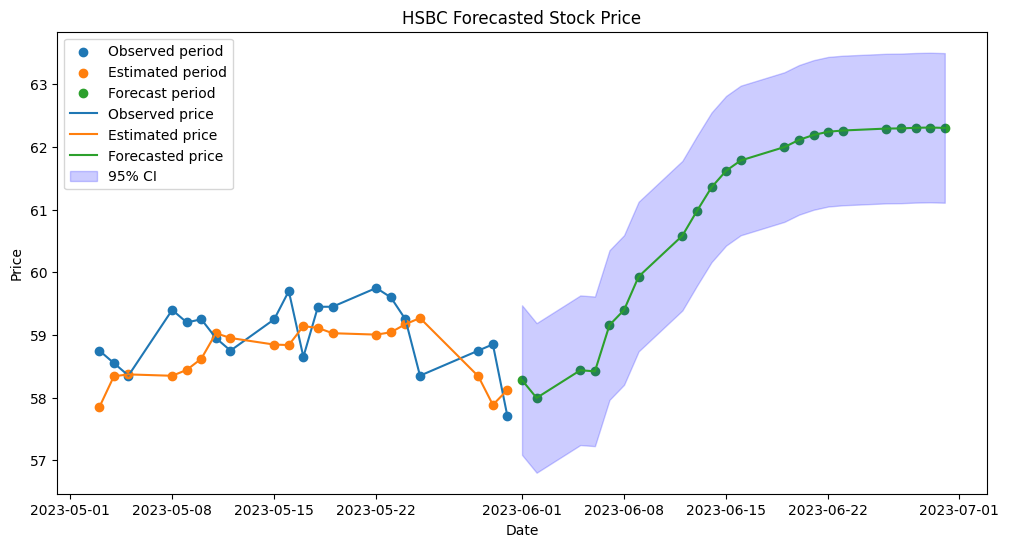

In [108]:
# plotting result for Task 3
forecast_price = np.array(forecast_period['Close'])

# create a scatter plot with Price on the y-axis and Date on the x-axis
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(observed_period.index, y_actual, label='Observed period')
ax.scatter(observed_period.index, observed_period['Close'], label='Estimated period')
ax.scatter(forecast_period.index, forecast_period['Close'], label='Forecast period')

# add lines for the observed period and forecast period
ax.plot(observed_period.index, y_actual, label='Observed price')
ax.plot(observed_period.index, observed_period['Close'], label='Estimated price')
ax.plot(forecast_period.index, forecast_period['Close'], label='Forecasted price')

# creating 95% CI
RMSFE = np.sqrt(sum([x**2 for x in residuals]) / len(residuals))
se = 1.96*RMSFE
upper_bound = forecast_price + se
lower_bound = forecast_price - se
ax.fill_between(forecast_period.index, upper_bound, lower_bound, alpha=0.2, label='95% CI', color='b')

ax.set_title('HSBC Forecasted Stock Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()

plt.show()